In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import accuracy_score

Step 0: load our data

In [3]:
# Load data
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/MSc thesis/processed_data/metadata/fully_concatenated_data.csv", lineterminator='\n')

In [4]:
data.iloc[1:10, 28:45]

,Hour,Day of Week (Number),Day of Week (String),Is_English,Detected_Language,Image_Count,image_0,image_1,image_2,image_3,image_4,image_5,image_6,image_7,image_8,image_9,image_10
1,20,6,Sunday,True,en,1,1.257535,4.292836,0.637026,0.038215,0.341019,0.103195,0.023346,0.352497,0.099513,0.015858,0.282103
2,15,6,Sunday,True,en,1,1.015909,4.928564,0.049328,1.360145,0.188817,0.242184,1.370974,0.206735,0.089321,0.008390,0.464875
3,18,2,Wednesday,True,en,7,0.612580,2.573719,0.000000,0.000000,1.416055,0.397631,1.642256,0.049719,0.000707,0.285212,0.627529
4,19,5,Saturday,True,en,1,0.961807,3.994127,0.116529,1.330238,0.034433,2.436250,0.633051,0.620503,3.313558,0.000000,0.139836
5,6,6,Sunday,False,ko,3,0.024685,0.956713,0.100529,0.715106,0.565287,0.084047,0.267570,0.000000,0.030411,0.600792,0.018151
6,15,6,Sunday,False,ko,2,0.000000,1.686701,0.022357,0.000000,0.007881,0.025374,0.328463,0.324222,0.000000,0.042074,0.056771
7,3,6,Sunday,False,ko,10,0.272321,1.318672,0.063117,0.000000,0.127826,0.154153,0.012882,0.257812,0.000000,0.082779,0.027158
8,3,6,Sunday,False,ko,10,1.009356,0.572479,0.049320,0.017962,0.707233,0.036858,0.366499,0.633115,0.058597,0.069269,0.271958
9,21,6,Sunday,True,en,1,1.316597,1.515859,0.067210,2.473874,0.316460,0.163660,0.673739,0.901117,0.219723,1.258277,0.542950


In [5]:
# List of image and text feature columns to keep
image_columns = [f'image_{i}' for i in range(0, 2049)]
text_columns = [f'text_{i}' for i in range(0, 768)]

# Additional columns you want to keep
additional_columns_to_keep = ['like_count', 'comment_count', 'post_id', 'Followers', 'Username', 'Image_Count']

# Combine both lists of columns to keep
columns_to_keep = image_columns + additional_columns_to_keep #+ text_columns

# Drop all columns except those specified in columns_to_keep
columns_to_drop = [col for col in data.columns if col not in columns_to_keep]

# Drop the unwanted columns from the dataframe
data_2 = data.drop(columns=columns_to_drop)


# Maybe don't delete category and detected languages
# Same with comments disabled and video
# potential columns to add or not:
#'comments_disabled',
#'is_video'
# Category
data_2.head(10)

# Filter image count to 10 or less, which is what is realistic in the industry
data_2 = data_2[data_2['Image_Count'] <= 1]

Step 1: group and split the data by post_id

Define a popularity variable

In [6]:
# Set the engagement rate variable
data_2['popularity'] = (((data_2['like_count'] + data_2['comment_count'])/data_2['Followers']))

<ipython-input-6-747e2ff0d805>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2['popularity'] = (((data_2['like_count'] + data_2['comment_count'])/data_2['Followers']))


Let's split the data!

In [7]:
# Define the number of iterations and an array to store accuracies
n_iterations = 7
accuracies = []

for seed in range(n_iterations):
    print(f"Iteration {seed+1}")

    # Split users into training and temporary sets with a new seed each time
    train_users, temp_users = train_test_split(data_2['Username'].unique(), test_size=0.2, random_state=seed)
    val_users, test_users = train_test_split(temp_users, test_size=0.5, random_state=seed)

    # Assign posts to training, validation, and test sets
    train_data = data_2[data_2['Username'].isin(train_users)]
    val_data = data_2[data_2['Username'].isin(val_users)]
    test_data = data_2[data_2['Username'].isin(test_users)]

    # Calculate the median popularity rate for each dataset
    median_popularity_rate_train = train_data['popularity'].quantile(0.5)
    train_data.loc[:, 'popularity'] = (train_data['popularity'] > median_popularity_rate_train).astype(int)
    median_popularity_rate_val = val_data['popularity'].quantile(0.5)
    val_data.loc[:, 'popularity'] = (val_data['popularity'] > median_popularity_rate_val).astype(int)
    median_popularity_rate_test = test_data['popularity'].quantile(0.5)
    test_data.loc[:, 'popularity'] = (test_data['popularity'] > median_popularity_rate_test).astype(int)

    # Prepare data for XGBoost
    X_train = train_data.drop(['popularity', 'post_id', 'like_count', 'comment_count', 'Username', 'Image_Count', 'Followers'], axis=1)
    y_train = train_data['popularity']
    X_val = val_data.drop(['popularity', 'post_id', 'like_count', 'comment_count', 'Username', 'Image_Count', 'Followers'], axis=1)
    y_val = val_data['popularity']
    X_test = test_data.drop(['popularity', 'post_id', 'like_count', 'comment_count', 'Username', 'Image_Count', 'Followers'], axis=1)
    y_test = test_data['popularity']

    # Convert datasets to LightGBM dataset format
    train_data_lgb = lgb.Dataset(X_train, label=y_train)
    val_data_lgb = lgb.Dataset(X_val, label=y_val)
    test_data_lgb = lgb.Dataset(X_test, label=y_test)

    # Define XGBoost model parameters
    params = {
        'objective': 'binary',
        'metric': 'binary_error',
        'alpha': 0.9,
        'learning_rate': 0.1
    }

    # Train the model
    # Train the LightGBM model
    bst = lgb.train(params,
                  train_data_lgb,
                  valid_sets=[train_data_lgb, val_data_lgb, test_data_lgb],
                  callbacks = [lgb.early_stopping(stopping_rounds=25)],
                  num_boost_round=1000)

    # Evaluate the model on the test set
    y_pred_prob = bst.predict(X_test)
    y_pred_binary = (y_pred_prob > 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_pred_binary)
    accuracies.append(accuracy)

    print(f"Accuracy for iteration {seed+1}: {accuracy:.2f}")

# Calculate the average accuracy across all iterations
average_accuracy = np.mean(accuracies)
print(f"Average Accuracy across {n_iterations} iterations: {average_accuracy:.2f}")

Iteration 1
[LightGBM] [Info] Number of positive: 53447, number of negative: 53447
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.504805 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 522240
[LightGBM] [Info] Number of data points in the train set: 106894, number of used features: 2048
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[6]	training's binary_error: 0.418789	valid_1's binary_error: 0.431757	valid_2's binary_error: 0.433589
Accuracy for iteration 1: 0.57
Iteration 2
[LightGBM] [Info] Number of positive: 53435, number of negative: 53435
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.379303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 522240
[LightGBM] [Info] Number of data

In [8]:
# Alternatively, using numpy to generate bootstrap samples and calculate the percentiles
# Determine the size of the accuracies array
n = len(accuracies)
bootstrap_samples = np.random.choice(accuracies, (10000, n), replace=True)
ci_lower = np.percentile(bootstrap_samples, 2.5)
ci_upper = np.percentile(bootstrap_samples, 97.5)

print(f"Bootstrap 95% Confidence Interval: {ci_lower:.5f} - {ci_upper:.5f}")

Bootstrap 95% Confidence Interval: 0.55598 - 0.57773


[0.39925769 0.44091139 0.43048921 ... 0.60300143 0.4565003  0.45671404]


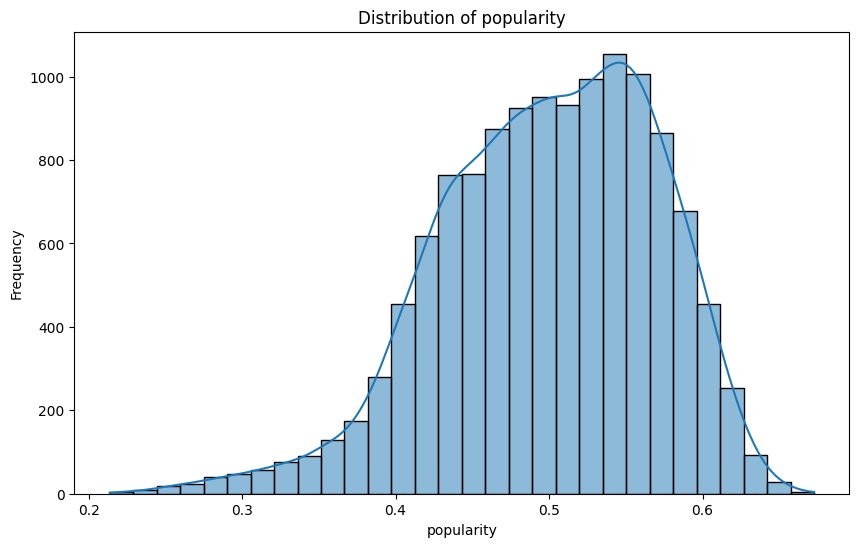

In [9]:
y_pred = bst.predict(X_test)
print(y_pred)

plt.figure(figsize=(10, 6))
sns.histplot(y_pred, bins=30, kde=True)
plt.title('Distribution of popularity')
plt.xlabel('popularity')
plt.ylabel('Frequency')
plt.show()

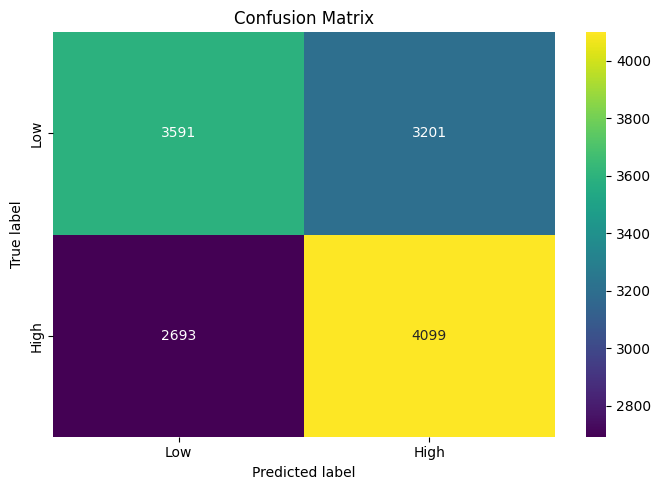

              precision    recall  f1-score   support

         Low       0.57      0.53      0.55      6792
        High       0.56      0.60      0.58      6792

    accuracy                           0.57     13584
   macro avg       0.57      0.57      0.57     13584
weighted avg       0.57      0.57      0.57     13584



In [10]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, X_test, y_test, type_of_model):
    # Predicting the probabilities for the test set
    y_pred_prob = model.predict(X_test)
    # Convert probabilities to binary labels
    y_pred = (y_pred_prob > 0.5).astype(int)

    # y_test should already be binary labels
    y_true = y_test.astype(int)

    # Generating the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Generating the classification report
    clr = classification_report(y_true, y_pred, target_names=['Low', 'High'])

    # Plotting the confusion matrix
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    # Show plot
    plt.show()

    # Print the classification report
    print(clr)

# Example usage
evaluate_model(bst, X_val, val_data['popularity'], 'LightGBM')

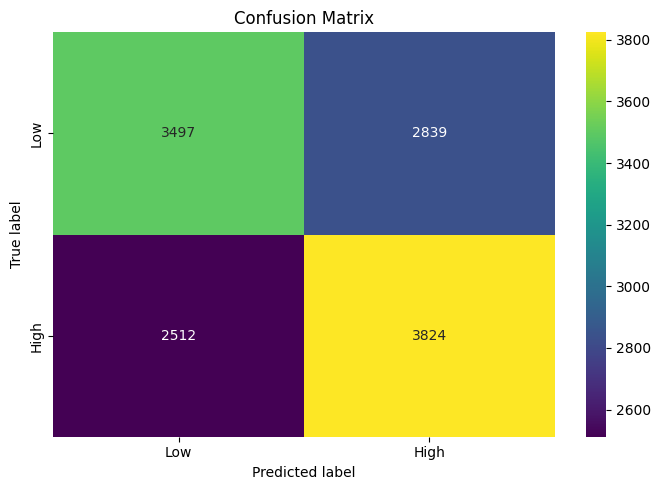

              precision    recall  f1-score   support

         Low       0.58      0.55      0.57      6336
        High       0.57      0.60      0.59      6336

    accuracy                           0.58     12672
   macro avg       0.58      0.58      0.58     12672
weighted avg       0.58      0.58      0.58     12672



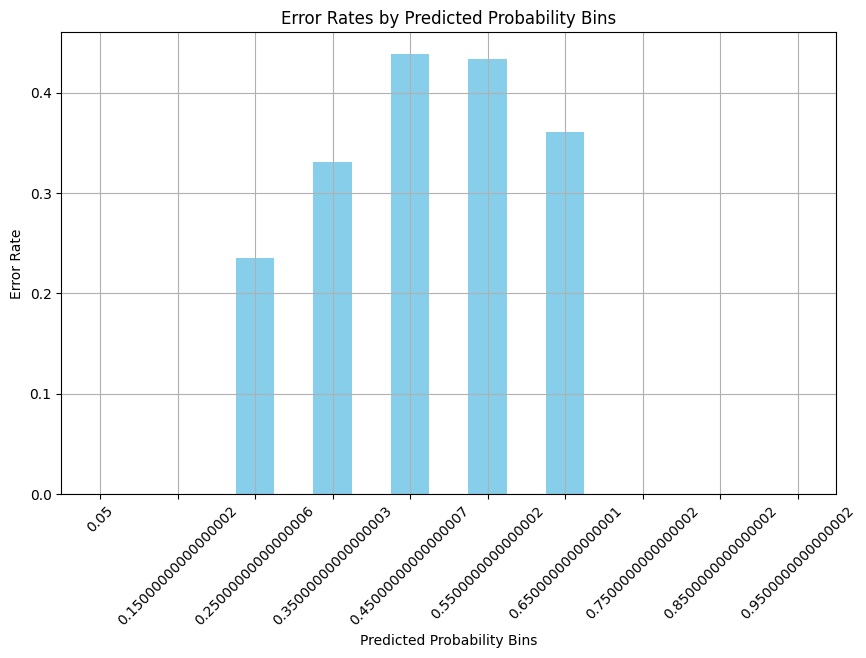

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_model_and_error_rates(model, X_test, y_test):
    # Predicting the probabilities for the test set
    y_pred_prob = model.predict(X_test)

    # Convert probabilities to binary labels
    y_pred = (y_pred_prob > 0.5).astype(int)

    # y_test should already be binary labels
    y_true = y_test.astype(int)

    # Generating the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Generating the classification report
    clr = classification_report(y_true, y_pred, target_names=['Low', 'High'])

    # Plotting the confusion matrix
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

    # Print the classification report
    print(clr)

    # Calculate error rates by probability bins
    results = pd.DataFrame({
        'y_true': y_true,
        'y_pred_prob': y_pred_prob
    })

    results['prob_bin'] = pd.cut(results['y_pred_prob'], bins=np.arange(0, 1.1, 0.1), labels=np.arange(0.05, 1.05, 0.1))

    # Calculate error rates
    error_rates = results.groupby('prob_bin').apply(
        lambda x: np.mean(x['y_true'] != (x['y_pred_prob'] > 0.5))
    )

    # Plotting error rates by predicted probability bins
    plt.figure(figsize=(10, 6))
    error_rates.plot(kind='bar', color='skyblue')
    plt.title('Error Rates by Predicted Probability Bins')
    plt.xlabel('Predicted Probability Bins')
    plt.ylabel('Error Rate')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

# Example usage
evaluate_model_and_error_rates(bst, X_test, test_data['popularity'])